In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys
import time

from collections import defaultdict

from blackjack import BlackjackEnv
import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [3]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        # Implement this!
        probs = np.ones(nA)*epsilon/nA
        probs[np.argmax(Q[observation])] += (1.0 - epsilon)
        return probs
    return policy_fn

In [52]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    # Implement this!
    for i in range(1,num_episodes+1):
        if i % 1000 == 0:
            print("\rEpisode {}/{}.".format(i, num_episodes), end="")
            sys.stdout.flush()
        episode = list()
        state = env.reset()
        for t in range(80):
            probs = policy(state)
            action = np.random.choice([0,1], p=probs)
            state_t_1, reward, done, empty = env.step(action)
            episode.append((state,action,reward))
            if not done:
                state = state_t_1
            else:
                break
        episode_state_act = set([(e[0],e[1]) for e in episode])
        for state,action in episode_state_act:
            state_action = (state,action)
            first_occurence_idx = next(j for j,e in enumerate(episode) if e[0] == state and e[1] == action)
            G = sum([e[2]*(discount_factor**j) for j,e in enumerate(episode[first_occurence_idx:])])
            returns_sum[state_action] += G
            returns_count[state_action] += 1.0
            Q[state][action] = returns_sum[state_action] / returns_count[state_action]
    return Q, policy

In [62]:
start = time.clock()

Q, policy = mc_control_epsilon_greedy(env, num_episodes=750000, epsilon=0.1)

end = time.clock()
print("\n",end - start,"s")

Episode 750000/750000.
 119.45555100000001 s


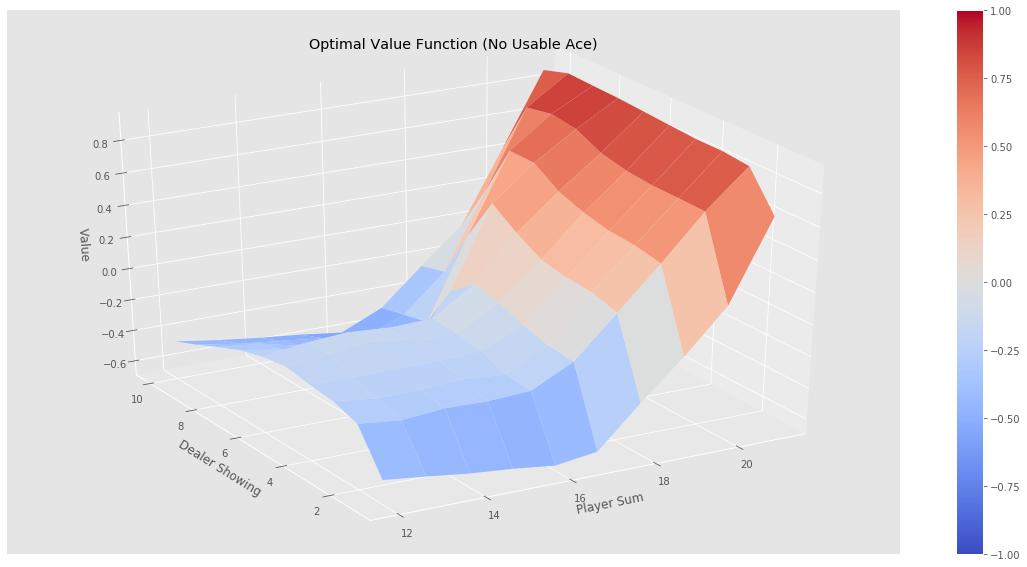

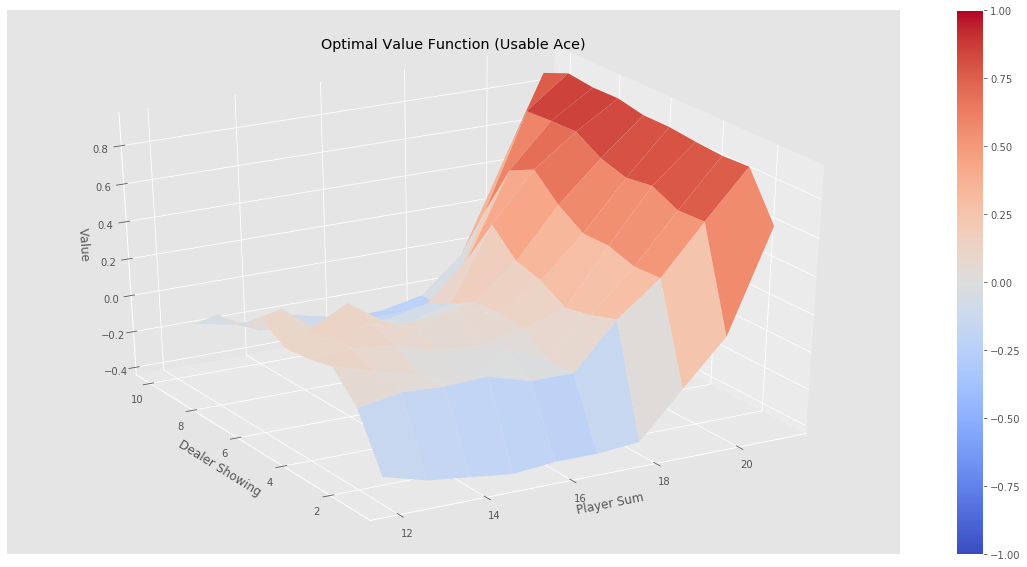

In [63]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")

[0.5, 10.5, 11, 21]

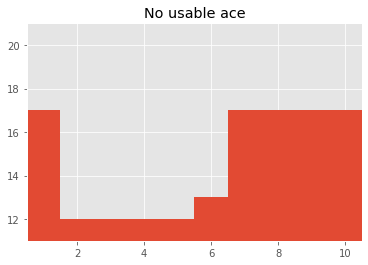

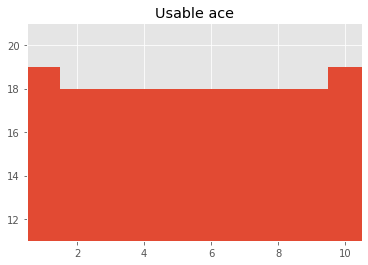

In [67]:
min_x = min(k[1] for k in Q.keys())
max_x = max(k[1] for k in Q.keys())
min_y = min(k[0] for k in Q.keys())
max_y = max(k[0] for k in Q.keys())

noace = [[k[1],k[0],np.argmax(Q[k])] for k in Q if not k[2]]
ace = [[k[1],k[0],np.argmax(Q[k])] for k in Q if k[2]]

def plot_policy(elements):
    y = list()
    x = list()
    for i in elements:
        if i[0] not in x and i[2]==0:
            x.append(i[0])
            y.append(i[1])
        elif i[0] in x and i[2]==0:
            idx = x.index(i[0])
            y[idx] = min(i[1], y[idx])
    return zip(*sorted(zip(x, y)))

noace_x, noace_y = plot_policy(noace)
ace_x, ace_y = plot_policy(ace)

matplotlib.pyplot.bar(noace_x,noace_y,width=1.0)
matplotlib.pyplot.title('No usable ace')
matplotlib.pyplot.axis([min_x - 0.5, max_x + 0.5, min_y - 1, max_y])
matplotlib.pyplot.figure()
matplotlib.pyplot.bar(ace_x,ace_y,width=1.0)
matplotlib.pyplot.title('Usable ace')
matplotlib.pyplot.axis([min_x - 0.5, max_x + 0.5, min_y - 1, max_y])